# COURSE: Master statistics and machine learning: Intuition, Math, code
##### COURSE URL: udemy.com/course/statsml_x/?couponCode=202006 
## SECTION: The t-test family
### VIDEO: Permutation testing
#### TEACHER: Mike X Cohen, sincxpress.com

In [11]:
# import libraries
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [12]:
# simulate two distributions

rng = np.random.default_rng()

# number of trials
N = 100

# dataset "A"
r = rng.standard_normal(size=N)
# r = np.random.randn(N)
r[r > 0] = np.log(1 + r[r > 0])
dataA = 26 - r*10

# get histogram values for later comparison
yA, xA = np.histogram(dataA, 20)
xA = (xA[:-1] + xA[1:])/2  # centers of bins

# dataset "B"
r = rng.standard_normal(size=N)
# r = np.random.randn(N)
r[r > 0] = np.log(1 + r[r > 0])
dataB = 30 - r*10

# get histogram values for later comparison
yB, xB = np.histogram(dataB, 20)
xB = (xB[:-1] + xB[1:])/2  # centers of bins

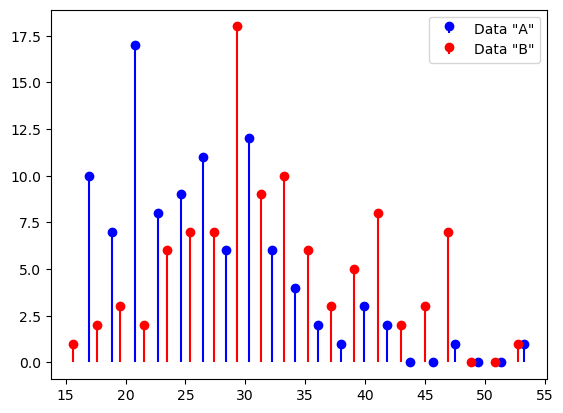

In [13]:
plt.stem(xA, yA, linefmt='b', markerfmt='bo', basefmt=' ', label='Data "A"')
plt.stem(xB, yB, linefmt='r', markerfmt='ro', basefmt=' ', label='Data "B"')
plt.legend()
plt.show()

In [4]:
# Немного в сторону - функция np.histogram и её связь с функцией плотности вероятности
# (a.k.a. pdf)

# Ключ density=True функции np.histogram приводит к следующей нормировке:
# сумма площадей бинов гистограммы равняется единице.
# Чтобы найти площадь бина, нужно его значение по y перемножить со значением по х.
hist_t, bin_edges_t = np.histogram(dataA, 15, density=True)
bin_width = np.mean(np.diff(bin_edges_t))
print(np.sum(hist_t*bin_width))

0.9999999999999999


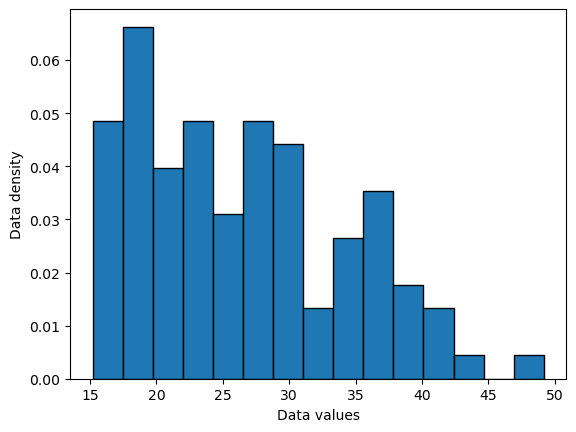

In [5]:
# Забавно, но используя аутпут np.histogram визуализировать гистограмму -
# задача довольно нетривиальная. Используете, дети, plt.hist.

hist_t, bin_edges_t = np.histogram(dataA, 15, density=True)
bin_width = np.mean(np.diff(bin_edges_t))
plt.bar(x=bin_edges_t[:-1], height=hist_t, width=np.diff(bin_edges_t),
        edgecolor='black', align='edge')
plt.xlabel('Data values')
plt.ylabel('Data density')
plt.show()

# Тоже самое, что
# plt.hist(x=dataA, bins=15, density=True, edgecolor='black');

In [6]:
# mix trials together

# concatenate trials
alldata = np.hstack((dataA, dataB))

# condition labels
# an array of twos
conds = np.hstack((np.ones(N), 2*np.ones(N)))

In [14]:
# generate one null hypothesis scenario

# random permutation
# создаёт массив, в котором в случайном порядке размещены значения от 0 до 199
fakeconds = rng.permutation(2*N)  # = len(alldata)
# fakeconds = np.random.permutation(N*2)

# shuffled condition labels
# 1) Все значения fakeconds < N (т.е. от 0 до 99) приравниваются к 1
fakeconds[fakeconds < N] = 1
# 2) Значения fakeconds >= N приравниваются к 2
fakeconds[fakeconds > 1] = 2

# these two means should be different.
# По сути, печать средних значений первого и второго наборов данных
print([np.mean(alldata[conds == 1]), np.mean(alldata[conds == 2])])

# should these two be different?
print([np.mean(alldata[fakeconds == 1]), np.mean(alldata[fakeconds == 2])])

[26.51738248318748, 33.635551384239854]
[29.512646446374525, 30.640287421052832]


In [15]:
# and now a distribution of null hypothesis values

nPerms = 1000
permdiffs = np.zeros(nPerms)

# повторение из предыдущей ячейки для nPerms перетасовок
for permi in range(nPerms):
    fconds = rng.permutation(2*N)
    fconds[fconds < N] = 1
    fconds[fconds > 1] = 2
    # Расчёт статистики для текущего permutation, сохранение результата в массив
    # нет необходимости делить на что-либо
    permdiffs[permi] = np.mean(alldata[fconds == 2]) - \
        np.mean(alldata[fconds == 1])

# Расчёт статистики для исходного набора данных
obsval = np.mean(alldata[conds == 2]) - np.mean(alldata[conds == 1])

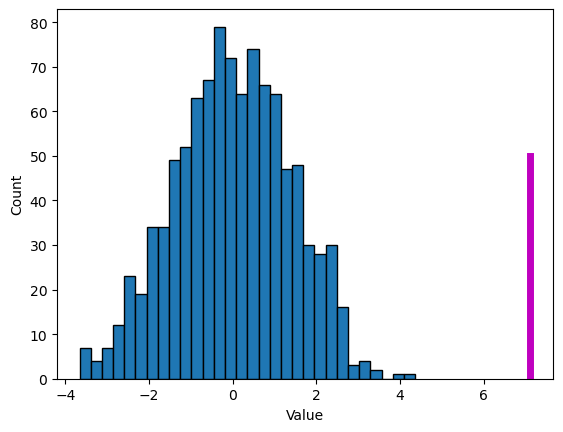

In [16]:
# plot the distribution of H0 values
plt.hist(permdiffs, 30, edgecolor='black')
# and plot the observed value on top
plt.plot([obsval, obsval], [0, 50], 'm', linewidth=5)
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [10]:
# two methods of evaluating statistical significance

# 1) t-value to Z-score
zVal = (obsval - np.mean(permdiffs)) / np.std(permdiffs, ddof=1)
# Cumulative distribution function от минус бесконечности до a -
# это есть площадь под графиком функции плотности (массы) распределения левее значения а.
# Площадь (интеграл) всей функции распределения должна быть равна 1.
# Значение определенного интеграла функции плотности (вероятности) распределения есть
# вероятность того, что случайная величина примет значение из пределов интегрирования.

# Поскольку нам нужно понять, какова вероятность того, что случайная величина принимает
# значение больше наблюдённого, мы можем:
# 1) посчитать интеграл функции плотности распределения от наблюдённого значения до бесконечности;
# 2) вычесть из общей площади (которая равна 1) площадь части подграфика
# функции плотности распределения, что лежит левее наблюдённого значения.
# При использовании второго варианта нужно учесть подводный камень - а что, если zVal меньше 0?
# Поскольку нормальное распределение симметрично, p(z > Zval) при zVal > 0 равно
# p(z < Zval) при zVal < 0. Следовательно, вешаем на Zval модуль и не думаем о знаке.
p = 1 - stats.norm.cdf(np.abs(zVal))

# 2) p-value count
pCount = np.sum(permdiffs > obsval) / nPerms
# В данном случае нужно быть осторожным с выбором направления неравенства
# Так, в данном случае мы тестируем только правый хвост!

print(p, pCount)

1.060139209752009e-08 0.0
